In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.multivariate.pca import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
import numpy as np
import seaborn as sns

from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers import LeakyReLU
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = pd.read_csv("domain_df.csv", index_col="Date")

In [ ]:
dataset

,TPS_Q1_DAY,TWAS_DAF_QIN_DAY,DIGESTED_SLUDGE_QOUT_DAY,BIOGAS_PRODUCTION_Q_DAY,DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK
Date,,,,,
2012-01-01,199.5,242.5,414,5.064,32.1
2012-01-02,199.5,165.5,392,5.293,32.1
2012-01-03,199.5,241.5,428,5.609,32.1
2012-01-04,170.0,194.0,354,4.470,31.8
2012-01-05,199.5,193.5,383,2.848,31.4
...,...,...,...,...,...
2014-04-26,199.5,271.5,470,1.824,32.0
2014-04-27,199.5,188.5,390,1.670,30.0
2014-04-28,199.5,185.5,392,1.613,32.0


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('BIOGAS_PRODUCTION_Q_DAY')
test_labels = test_features.pop('BIOGAS_PRODUCTION_Q_DAY')

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
TPS_Q1_DAY,173.985301,58.971872
TWAS_DAF_QIN_DAY,248.418517,69.720230
DIGESTED_SLUDGE_QOUT_DAY,421.033774,101.776140
BIOGAS_PRODUCTION_Q_DAY,3.375549,0.782232
DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK,30.806511,1.291812


In [ ]:
normalizer = preprocessing.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

[173.98532 248.4185  421.03378  30.80651]


In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[199.5  252.5  465.    30.61]]

Normalized: [[ 0.43  0.06  0.43 -0.15]]


In [ ]:
TPS_Q1_DAY = np.array(train_features['TPS_Q1_DAY'])

TPS_Q1_DAY_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
TPS_Q1_DAY_normalizer.adapt(TPS_Q1_DAY)

In [ ]:
TPS_Q1_DAY_model = tf.keras.Sequential([
    TPS_Q1_DAY_normalizer,
    layers.Dense(units=1)
])

TPS_Q1_DAY_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
TPS_Q1_DAY_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = TPS_Q1_DAY_model.fit(
    train_features['TPS_Q1_DAY'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 4.55 s, sys: 625 ms, total: 5.17 s
Wall time: 4.53 s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.620896,0.607815,95
96,0.610913,0.599511,96
97,0.610522,0.611289,97
98,0.624875,0.602376,98
99,0.608597,0.592887,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Biogas]')
  plt.legend()
  plt.grid(True)

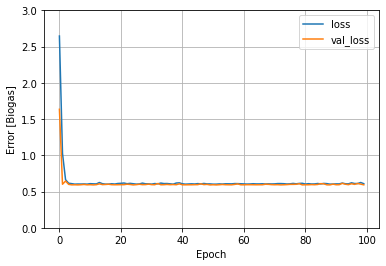

In [ ]:
plot_loss(history)


In [ ]:
test_results = {}

test_results['TPS_Q1_DAY_model'] = TPS_Q1_DAY_model.evaluate(
    test_features['TPS_Q1_DAY'],
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(2.0, 5.0, 251)
y = TPS_Q1_DAY_model.predict(x)

In [ ]:
def plot_TPS_Q1_DAY(x, y):
  plt.scatter(train_features['TPS_Q1_DAY'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('TPS_Q1_DAY')
  plt.ylabel('Biogas')
  plt.legend()

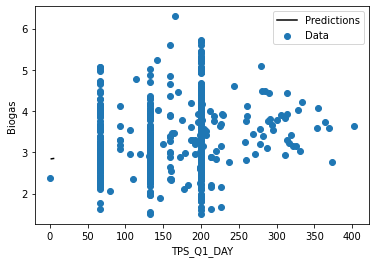

In [ ]:
plot_horsepower(x,y)

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 4.32 s, sys: 529 ms, total: 4.85 s
Wall time: 3.2 s


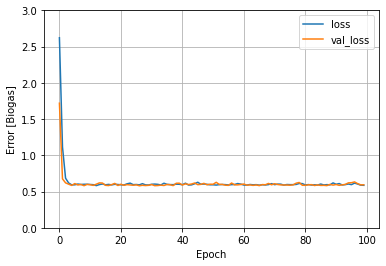

In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
train_features.shape

(681, 4)

In [ ]:
def build_and_compile_model(norm):
  lrelu = lambda x: tf.keras.layers.LeakyReLU(alpha=0.1)(x)
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation=lrelu),
      layers.Dense(64, activation=lrelu),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 553 ms, sys: 82.6 ms, total: 635 ms
Wall time: 443 ms


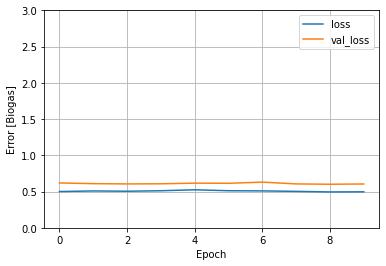

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [ ]:
pd.DataFrame(test_results, index=['MAE [Biogas]']).T

,MAE [Biogas]
TPS_Q1_DAY_model,0.605550
linear_model,0.630016
dnn_model,0.614139


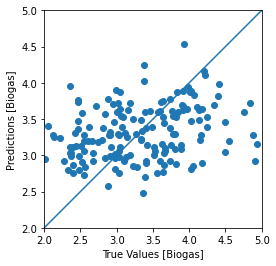

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Biogas]')
plt.ylabel('Predictions [Biogas]')
lims = [2, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

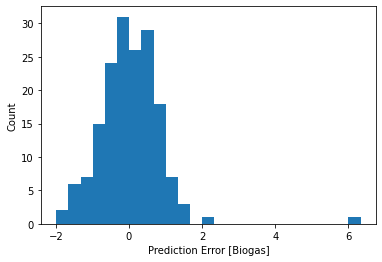

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Biogas]')
_ = plt.ylabel('Count')

In [ ]:
# MAPE
error = np.abs((test_predictions - test_labels)/test_labels)

print(f"Accuracy is: {100-(np.mean(error)*100)}")

Accuracy is: 81.74301146098695


In [ ]:
test_predictions[test_predictions>10] = test_predictions.mean()

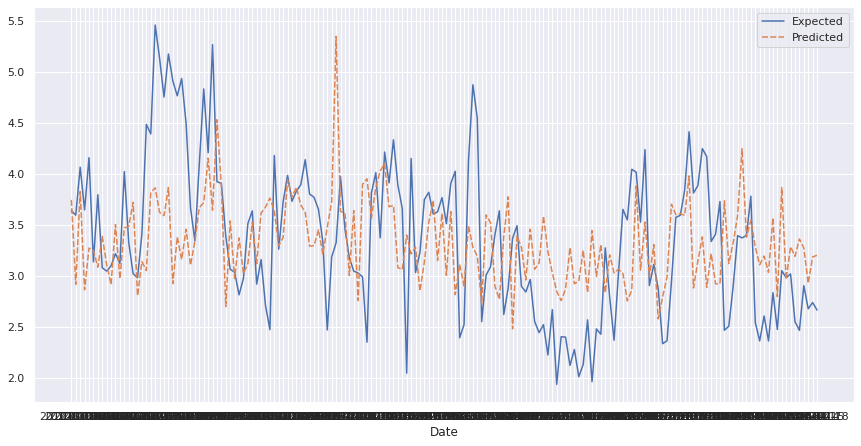

In [ ]:
results = pd.DataFrame(columns=["Expected", "Predicted"])#"Expected_Trend", "Predicted_Trend"])
results["Expected"] = test_labels
#results["Expected_Trend"] = results['Expected'].rolling(3).mean()

results["Predicted"] = test_predictions
#results["Predicted_Trend"] = results['Predicted'].rolling(3).mean()


sns.set(rc={'figure.figsize':(14.7,7.27)})
sns.lineplot(data=results,palette="deep")